In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install gymnasium
!pip install pygame

In [ ]:
import gymnasium as gym
import numpy as np

env = gym.make("CartPole-v1")
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n

alpha = 0.1
gamma = 0.99
epsilon = 0.1
episodes = 500
sync_n = 20

def epsilon_greedy(q_network, state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # unsqueeze the state, put it into Q, get the values, then argmax to find optimal action
    q_values = q_network(state_tensor)
    return int(torch.argmax(q_values))


In [ ]:
import torch
import torch.nn as nn

class DuelingMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(128, 128)):
        super().__init__()
        # Layer shared between value and advantage stream
        self.share = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU()
        )
        # Value stream layer
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], 1)
        )
        # Advantage stream layer
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], output_dim)
        )

    def forward(self, x):
        x = self.share(x)
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        # value, advantage.mean() broadcasts along the advantage vector
        q = value + advantage - advantage.mean(dim=1, keepdim=True)
        return q



In [ ]:
# Inherits the architecture of DDQN
Q_online = DuelingMLP(n_states, n_actions)
Q_target = DuelingMLP(n_states, n_actions)
Q_target.load_state_dict(Q_online.state_dict())
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(Q_online.parameters(), lr=0.001)

In [ ]:
!pip install tqdm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Same as DDQN
from tqdm import tqdm

global_step = 0

for ep in tqdm(range(episodes), desc="Training Progress"):
    state, _ = env.reset()
    done = False

    while not done:
        action = epsilon_greedy(Q_online, state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        if global_step % sync_n == 0:
            Q_target.load_state_dict(Q_online.state_dict())

        global_step += 1

        state_tensor = torch.tensor(np.array(state), dtype=torch.float32).unsqueeze(0)
        next_state_tensor = torch.tensor(np.array(next_state), dtype=torch.float32).unsqueeze(0)

        next_action = torch.argmax(Q_online(next_state_tensor)).item()

        q_pred = Q_online(state_tensor)[0, action]


        with torch.no_grad():
            q_reward = reward + gamma * Q_target(next_state_tensor)[0, next_action] * (1 - int(done))

        loss = loss_fn(q_pred, q_reward)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state


Training Progress: 100%|██████████| 500/500 [03:11<00:00,  2.61it/s]


Average reward over 10 test episodes: 156.2


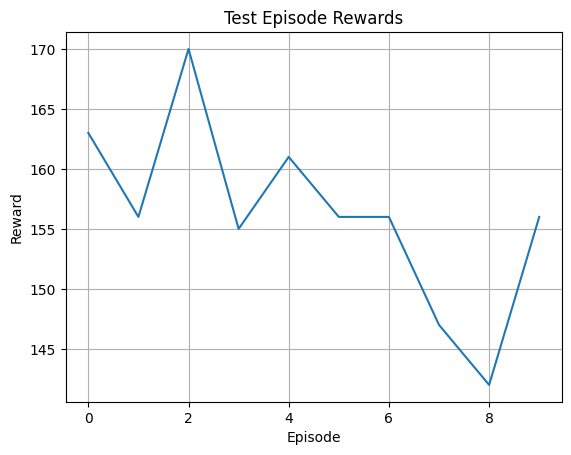

In [ ]:
import matplotlib.pyplot as plt

test_episodes = 10
rewards = []

for _ in range(test_episodes):
    state, _ = env.reset()
    done = False
    ep_reward = 0

    while not done:
        action = epsilon_greedy(Q_online, state, epsilon=0.0)  # always exploit
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        ep_reward += reward
        state = next_state

    rewards.append(ep_reward)

print("Average reward over", test_episodes, "test episodes:", np.mean(rewards))

# Optional: plot rewards
plt.plot(rewards)
plt.title("Test Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.show()


In [ ]:
### Shows a worse performance than DDQN. Supposedly since there are more parameters to train, and we are training only 500 steps in also a very simple game so it's advantageous to have less parameters.

In [ ]:
from gymnasium.wrappers import RecordVideo
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(env, video_folder="/content/videos", name_prefix="cartpole-test", episode_trigger=lambda x: True)

state, _ = env.reset()
done = False
while not done:
    action = epsilon_greedy(Q_online, state, epsilon=0.0)
    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

env.close()
